In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import statsmodels.api as sm

sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')
from sklearn.model_selection import train_test_split

In [32]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MED4',  'MIT9312','MIT0604', 'Natl2A', 'MIT9313']
ppallete = [ '#62A586', '#face6e','#f79934', '#7A9BC8', '#F47681', ]
psizes = [150,120,200,120,350]
pmarkers = ['o', 's', '^', 'D', '*']

# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
amarkers = ['P', 'X', 'h', '<','>']
apallete = ['#6dad36', '#c7e89f', '#f5c4e1', '#d5579d', '#8a0850']

aedge='orange'
epallete = ['#6cf0ba', '#d13f75', '#eeb7cb', '#b9d2d8', '#407f90']
#sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e1','e3', 'e4', 'e5', 'e6']
#aedge='orange'

espallete = ['#6cf0ba', '#D55282', '#538B9B']

In [34]:
sns.set_context('poster')
sns.set_style('white')

In [40]:
allsheets = pd.read_excel( 'percpA mean.xlsx', sheet_name=None)

In [41]:
allsheets.keys()

dict_keys(['60 days', '100 days', '140 days', 'summary', 'Sheet2', 'Sheet1', 'Peak and Max FL '])

In [42]:
for i in ['60 days', '100 days', '140 days']:
    allsheets[i]['day'] = i
df= pd.concat([allsheets[i] for i in ['60 days', '100 days', '140 days'] ])

In [43]:
df

,Sample,Unnamed: 1,PRO | Mean (PerCP-Cy5-5-A),Ave 60 Days,SD,day,Ave 100 Days,Unnamed: 3,Unnamed: 4
0,1A,Specimen_001_Tube_02_001.fcs,344.0,NaN,NaN,60 days,NaN,NaN,NaN
1,1B,Specimen_001_Tube_03_002.fcs,324.0,NaN,NaN,60 days,NaN,NaN,NaN
2,1C,Specimen_001_Tube_04_003.fcs,314.0,327.333333,15.275252,60 days,NaN,NaN,NaN
3,2A,Specimen_001_Tube_05_004.fcs,787.0,NaN,NaN,60 days,NaN,NaN,NaN
4,2B,Specimen_001_Tube_06_005.fcs,708.0,NaN,NaN,60 days,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
111,36C,Specimen_002_Tube_40_114.fcs,316.0,NaN,NaN,140 days,NaN,348.000000,41.581246
112,37A,Specimen_003_Tube_02_115.fcs,705.0,NaN,NaN,140 days,NaN,NaN,NaN
113,37B,Specimen_003_Tube_03_116.fcs,650.0,NaN,NaN,140 days,NaN,NaN,NaN
114,37C,Specimen_003_Tube_04_117.fcs,902.0,NaN,NaN,140 days,NaN,752.333333,132.500314


In [44]:
df.isna().sum()

Sample                          2
Unnamed: 1                      1
PRO | Mean (PerCP-Cy5-5-A)      3
Ave 60 Days                   313
SD                            277
day                             0
Ave 100 Days                  308
Unnamed: 3                    308
Unnamed: 4                    308
dtype: int64

In [45]:
dfm = pd.read_pickle('CCPA.pkl.gz')
dfm.loc[dfm.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [46]:
dfm.head()

,day,experiment,sample,FL,PRO,ALT,culture,FL_orig,logFL,cumsumFL,cumsumlogFL,zscoreFL,diffFL,difflogFL,diffday,rateFL,ratelogFL,experiment_sample
0,0.000000,e1,1A,0.133,MED4,1A3,Co_Culture,0.133,-2.017406,0.133,-2.017406,-0.588889,NaN,NaN,NaN,NaN,NaN,"e1, 1A"
1,0.715972,e1,1A,0.159,MED4,1A3,Co_Culture,0.159,-1.838851,0.292,-3.856257,-0.575917,0.026,0.178555,0.715972,0.036314,0.249388,"e1, 1A"
2,1.925694,e1,1A,0.155,MED4,1A3,Co_Culture,0.155,-1.864330,0.447,-5.720587,-0.577913,-0.004,-0.025479,1.209722,-0.003307,-0.021062,"e1, 1A"
3,2.831250,e1,1A,0.180,MED4,1A3,Co_Culture,0.180,-1.714798,0.627,-7.435386,-0.565440,0.025,0.149532,0.905556,0.027607,0.165127,"e1, 1A"
4,6.674306,e1,1A,0.632,MED4,1A3,Co_Culture,0.632,-0.458866,1.259,-7.894252,-0.339936,0.452,1.255933,3.843056,0.117615,0.326806,"e1, 1A"


In [47]:
metadf = dfm.groupby(['sample', 'PRO', 'ALT', 'culture'])['FL'].count().reset_index()

In [48]:
metadf

,sample,PRO,ALT,culture,FL
0,10A,MIT0604,DE,Co_Culture,446
1,10B,MIT0604,DE,Co_Culture,446
2,10C,MIT0604,DE,Co_Culture,446
3,11A,MED4,DE1,Co_Culture,446
4,11B,MED4,DE1,Co_Culture,446
...,...,...,...,...,...
86,8B,MIT9312,DE,Co_Culture,446
87,8C,MIT9312,DE,Co_Culture,446
88,9A,Natl2A,DE,Co_Culture,446
89,9B,Natl2A,DE,Co_Culture,367


In [49]:
df = df.merge(metadf[['sample', 'PRO', 'ALT', 'culture']], how='left', left_on='Sample', right_on='sample')

In [57]:
df = df.rename(columns={'PRO | Mean (PerCP-Cy5-5-A)' :'Perc'})

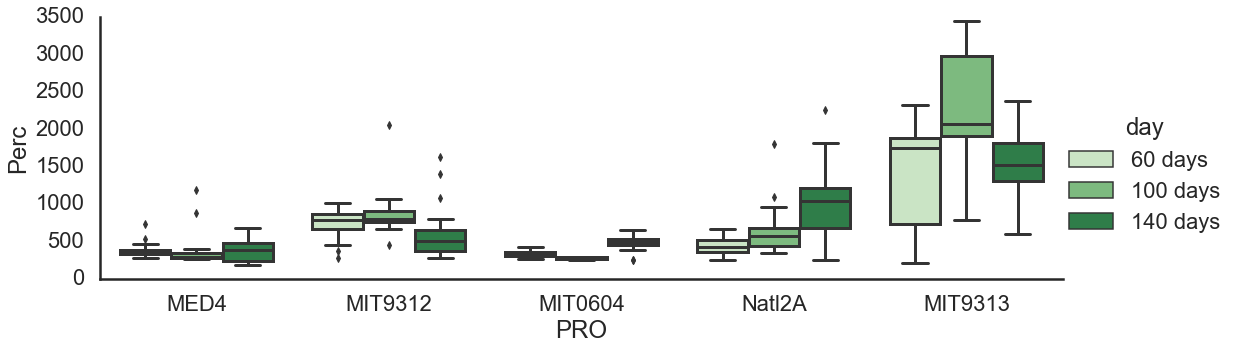

In [62]:
sns.catplot(data=df, x='PRO', y='Perc', hue='day', order=porder, palette='Greens',
           kind='box', aspect=3, )

In [63]:
from statsmodels.formula.api import ols
for p in porder:
    mod = ols(f'Perc ~ C(day) + C(ALT)',
                    data=df.loc[(df.PRO == p)]
             ).fit()
    print(f'--------------------------  {p} ----------------------------')
    print(mod.summary())
    print(sm.stats.anova_lm(mod))
    pair_t = mod.t_test_pairwise("C(day)", method='b')
    print(pair_t.result_frame)
    print(f'--------------------------  {p} ----------------------------')
    print(pair_t.result_frame.loc[pair_t.result_frame['reject-b'], 'pvalue-b'])
    #aov_table = sm.stats.anova_lm(mod, typ=2)
    #print(aov_table)

--------------------------  MED4 ----------------------------
                            OLS Regression Results                            
Dep. Variable:                   Perc   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     3.538
Date:                Sun, 17 Oct 2021   Prob (F-statistic):            0.00402
Time:                        11:55:50   Log-Likelihood:                -343.55
No. Observations:                  54   AIC:                             703.1
Df Residuals:                      46   BIC:                             719.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------